In [1]:
import blocksci

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
import collections
import random

In [4]:
from enum import Enum

In [5]:
import utils

In [6]:
date_string = "20210720"

In [7]:
chain = blocksci.Blockchain(utils.blocksci_config())

In [8]:
my_cm = blocksci.cluster.ClusterManager(utils.latest_clustering(), chain)

In [9]:
cluster_id = blocksci.heuristics.cluster_id(my_cm)

In [10]:
output_cluster_id = blocksci.heuristics.output_cluster_id(my_cm)

In [11]:
fp = blocksci.Fingerprinter(utils.latest_fingerprints(), chain)

In [12]:
heuristics = {
    "optimal_change": blocksci.heuristics.change.optimal_change,
    "optimal_change_with_fee": blocksci.heuristics.change.optimal_change_with_fee,
    "address_type": blocksci.heuristics.change.address_type,
    "power_of_ten_2": blocksci.heuristics.change.power_of_ten_value(2),
    "power_of_ten_3": blocksci.heuristics.change.power_of_ten_value(3),
    "power_of_ten_4": blocksci.heuristics.change.power_of_ten_value(4),
    "power_of_ten_5": blocksci.heuristics.change.power_of_ten_value(5),
    "power_of_ten_6": blocksci.heuristics.change.power_of_ten_value(6),
    "power_of_ten_7": blocksci.heuristics.change.power_of_ten_value(7),
    "fp_inout_count": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask([utils.Fingerprint.INPUT_COUNT, utils.Fingerprint.OUTPUT_COUNT])),
    "fp_output_count": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask(utils.Fingerprint.OUTPUT_COUNT)),
    "fp_version": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask(utils.Fingerprint.VERSION_2)),
    "fp_locktime": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask([utils.Fingerprint.LOCKTIME_HEIGHT, utils.Fingerprint.LOCKTIME_TIME])),
    "fp_rbf": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask(utils.Fingerprint.RBF)),
    "fp_segwit": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask(utils.Fingerprint.SEGWIT)),
    "fp_possible_segwit": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask(utils.Fingerprint.SEGWIT_COMPATIBLE)),
    "fp_ordered_inouts": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask(utils.Fingerprint.SORTED_INOUTS)),
    "fp_zeroconf": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask(utils.Fingerprint.ZEROCONF)),
    "fp_multisig": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask(utils.Fingerprint.MULTISIG)),
    "fp_p2pkh": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask(utils.Fingerprint.P2PKH)),
    "fp_p2sh": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask(utils.Fingerprint.P2SH)),
    "fp_p2wpkh": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask(utils.Fingerprint.P2WPKH)),
    "fp_p2wsh": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask(utils.Fingerprint.P2WSH)),
    "fp_address_type": blocksci.heuristics.change.smart_fingerprint(fp, utils.get_fp_mask([utils.Fingerprint.MULTISIG, utils.Fingerprint.P2PKH, utils.Fingerprint.P2SH, utils.Fingerprint.P2WPKH, utils.Fingerprint.P2WSH, utils.Fingerprint.ADDRESS_OTHER])),
    "fp_absolute_fee": blocksci.heuristics.change.fixed_fee,
    "fp_relative_fee": blocksci.heuristics.change.fixed_fee_per_byte,
}

In [13]:
column_labels = ["true_change"] + list(heuristics.keys()) + [
    "co_output_value",
    "co_is_larger_output",
    "co_output_value_ratio",
    "co_output_index",
    "co_fresh_output",
    "co_other_fresh",
    "ct_fee",
    "ct_fee_per_byte",
    "ct_tx_value",
    "ct_segwit_tx",
    "ct_has_locktime",
    "ct_version",
    "ct_block_height",
    "ct_input_count",
    "all_outputs_spent"
]

In [14]:
len(column_labels)

42

In [15]:
cluster_member = blocksci.heuristics.change.cluster_member(my_cm)

In [16]:
address_reuse = blocksci.heuristics.change.address_reuse

In [17]:
class HeuristicsResults(Enum):
    REUSE_CORRECT = 1
    REUSE_INCORRECT = 2
    CLUSTER_CORRECT = 3
    CLUSTER_INCORRECT = 4
    NONSTANDARD = 5
    NO_HEURISTICS = 6
    NO_HEURISTICS_NOFP = 7

In [18]:
def get_heuristics_for_tx(tx, spend_value=None, spend_index=None):
    
    # Our model only predicts change in transactions with 2 outputs
    assert tx.output_count == 2
    # We need either the index or the value of the spend to identify the output
    assert spend_value != None or spend_index != None
    
    # Since we only have transactions with two outputs, flip the spend index to get the change index
    change_index = None
    if spend_index is None:
        change_index = 1 - int(tx.outputs.where(lambda o: o.value == spend_value).index[0])
    else:
        change_index = 1 - spend_index
    
    # Check that the index is valid
    assert isinstance(change_index, int) and change_index in (0, 1)
    
    # Change output can be identified through address reuse
    if address_reuse(tx).size != 0:
        if address_reuse.unique_index(tx) == change_index:
            return HeuristicsResults.REUSE_CORRECT
        else:
            return HeuristicsResults.REUSE_INCORRECT
    
    # Change output can be identified through cluster membership
    if cluster_member(tx).size != 0:
        if cluster_member.unique_index(tx) == change_index:
            return HeuristicsResults.CLUSTER_CORRECT
        else:
            return HeuristicsResults.CLUSTER_INCORRECT
    
    
    output_list = []
    for output in tx.outputs:
        all_outputs_spent = tx.outputs.all(lambda o: o.is_spent)
        
        l = []
        
        l.append(int(output.index == change_index))
        
        heuristic_results = []
        for heuristic in heuristics.values():
            result = heuristic.unique_index(tx)
            out_result = int(result == output.index) if result != -1 else -1
            heuristic_results.append(out_result)
        l += heuristic_results
        
        # Check if we have heuristic results
        if all_outputs_spent:
            if all([x == -1 for x in heuristic_results]):
                return HeuristicsResults.NO_HEURISTICS
        else:
            if all([x == -1 for x in heuristic_results[:9]]):
                return HeuristicsResults.NO_HEURISTICS_NOFP
        
        # Add characteristics
        l.append(output.value)
        l.append(output.value == max(tx.outputs.value))
        l.append(output.value / tx.output_value)
        l.append(output.index)
        l.append(output.address.first_tx == output.tx)
        l.append(tx.outputs[1-output.index].address.first_tx == output.tx)
        l.append(tx.fee)
        l.append(tx.fee_per_byte())
        l.append(tx.output_value)
        l.append(tx.segwit)
        l.append(blocksci.heuristics.has_locktime(tx))
        l.append(tx.version)
        l.append(tx.block.height)
        l.append(tx.input_count)
        l.append(all_outputs_spent)
        output_list.append(l)
    
    df = pd.DataFrame(output_list)
    assert len(df.columns) == len(column_labels)
    df.columns = column_labels
    df.index = ["{}-{}".format(tx.hash, idx) for idx in range(tx.output_count)]
    
    return df

In [19]:
def get_ground_truth_df(gt_dict, reset_index=True, spend_values=True):
    STATS = collections.defaultdict(int)
    
    df = None
    
    counter = 0
    
    for txhash, v in gt_dict.items():
        
        counter += 1
        if counter % 50000 == 0:
            print("Progress: {} out of {} transactions".format(counter, len(gt_dict)))
        
        tx = chain.tx_with_hash(txhash)
        
        if tx.output_count != 2:
            STATS[HeuristicsResults.NONSTANDARD] += 1
            continue
        
        result = None
        if spend_values:
            result = get_heuristics_for_tx(tx, spend_value=int(v))
        else:
            result = get_heuristics_for_tx(tx, spend_index=int(v))
        
        if isinstance(result, HeuristicsResults):
            if result == HeuristicsResults.REUSE_CORRECT:
                STATS[HeuristicsResults.REUSE_CORRECT] += 1
            
            elif result == HeuristicsResults.REUSE_INCORRECT:
                STATS[HeuristicsResults.REUSE_INCORRECT] += 1
            
            elif result == HeuristicsResults.CLUSTER_CORRECT:
                STATS[HeuristicsResults.CLUSTER_CORRECT] += 1
            
            elif result == HeuristicsResults.CLUSTER_INCORRECT:
                STATS[HeuristicsResults.CLUSTER_INCORRECT] += 1
            
            elif result == HeuristicsResults.NO_HEURISTICS:
                STATS[HeuristicsResults.NO_HEURISTICS] += 1
                
            elif result == HeuristicsResults.NO_HEURISTICS_NOFP:
                STATS[HeuristicsResults.NO_HEURISTICS_NOFP] += 1
        else:            
            if df is not None:
                df = pd.concat([df, result])
            else:
                df = result
    
    if reset_index:
        df.reset_index(inplace=True, drop=True)
        
    print("Non-standard: {}".format(STATS[HeuristicsResults.NONSTANDARD]))
    print("No heuristics: All spent: {}, Unspent: {}".format(STATS[HeuristicsResults.NO_HEURISTICS], STATS[HeuristicsResults.NO_HEURISTICS_NOFP]))
    print("Reuse: Correct: {}, Incorrect: {}".format(STATS[HeuristicsResults.REUSE_CORRECT], STATS[HeuristicsResults.REUSE_INCORRECT]))
    print("Cluster: Correct: {}, Incorrect: {}".format(STATS[HeuristicsResults.CLUSTER_CORRECT], STATS[HeuristicsResults.CLUSTER_INCORRECT]))
        
    return df

## Ransomware

In [31]:
ransomware_csv = pd.read_csv("/home/ubuntu/Data/model-validation/cerber-locky-addresses.csv", index_col=0)

In [32]:
for txhash in ransomware_csv[ransomware_csv.txn_hash.duplicated()].txn_hash:
    if chain.tx_with_hash(txhash).output_count <= 2 :
        print(txhash)

In [33]:
ransomware_csv = ransomware_csv[~ransomware_csv.txn_hash.duplicated()]

In [34]:
len(ransomware_csv.txn_hash), len(set(ransomware_csv.txn_hash))

(16764, 16764)

In [35]:
ransomware_data = {tx: idx for tx, idx in zip(ransomware_csv.txn_hash.values, ransomware_csv.output_index.values)}

In [36]:
len(ransomware_data.items())

16764

In [37]:
ransomware_csv.head(15)

,family,txn_hash,output_index,potential_ransom_wallet_addr,potential_ransom_btc,potential_ransom_usd,unix_ts
0,Locky,55e5217e8ed11ac6f9fdd823ea13f5c2527c7c9b752072...,1,1AVcbgn3QJGJkDehF5LhcYhp81UZsZ9dWv,0.5,189.14,1455179567
1,Locky,a90614f93db39dd452bfd212fff0bbae542076bd2d0ad5...,0,1BtQCZgjL8ysrstULZQaGJ56nSikPa3mMb,1.0,403.01,1455550689
2,Locky,3949cd8f41dcaf24d1d4b3f0fad4b1ad749da3d83b186b...,0,1FMBqkio8ryWjtDhK1xvTGNHp4YZq4fcm7,1.0,403.01,1455572795
3,Locky,999b37dda5520e3b8f8bcd1caee5a64a2494b8a9d9c404...,1,192Zktbc4cNPhKs9rUavgNJjH6Rf7NXBqh,0.5,201.88,1455617510
4,Locky,cc500a54b6d226bdd27246f76d6d43c8c3154564a5fb6b...,0,14buRC3WParn4q8xh5HYnB2MQdVdgKVbU1,0.5,201.88,1455619349
5,Locky,496c905fc9dc91814ae833faf3ede87441e152e20e4545...,0,17BQkSoJGnp9kmZPptPDPeaJc4S4NpA8TF,0.5,201.88,1455632302
6,Locky,c8e7eb8fac1fcf42bc27a10063b3b30165fccb8432d1ac...,0,1KKo2c6YaennfXn4GnoAXV5JLZLiLUix35,1.0,403.75,1455633386
7,Locky,70bda91488d2c68b843d95530bf3b86d36e2b62a5331f0...,15,17fKMzBKcirBzcxgULinmppxZM6X66RkuK,0.5,201.88,1455636335
8,Locky,9c3ec8ae60aab222ea9c7c792ed2315f3223f50358bb0f...,12,1Y7XLJvS8XFiZPrQLH8f5D9Nb3tdenEgj,0.5,201.88,1455641395
9,Locky,72eba13d305e648800d8c94cf0d88ed34736d491be7e5e...,16,1JpcbXxBUMqoL2JL8PGDw2E4W1LxyTMr3D,1.0,403.75,1455641395


In [38]:
ransomware_df = get_ground_truth_df(ransomware_data, reset_index=False, spend_values=False)

Non-standard: 3057
No heuristics: All spent: 8, Unspent: 15
Reuse: Correct: 1636, Incorrect: 0
Cluster: Correct: 852, Incorrect: 0


In [39]:
ransomware_df.to_csv("/home/ubuntu/Data/model-validation/{}-ransomware-gt.csv".format(date_string))

### Intermediary interaction

In [41]:
import yaml

In [42]:
with open('walletexplorer.yaml') as f:
    cluster_tags = yaml.safe_load(f)

In [43]:
cluster_tags = cluster_tags['tags']

In [44]:
len(cluster_tags)

382

In [45]:
more_clusters = {}
for entry in cluster_tags:
    more_clusters[entry['label']] = entry['address']

In [46]:
seen_clusters = {}
for cluster_address in more_clusters.values():
    idx = my_cm.cluster_with_address(chain.address_from_string(cluster_address)).index
    if idx in seen_clusters:
        print(seen_clusters[idx], cluster_address)
    else:
        seen_clusters[idx] = cluster_address

1HwMuq4Ch7HiMtQ7is4ea5d7wSJjxuJAZi 17sLQNY8UAPrGdC7F2iFHbJDYFdctdRKqb


In [47]:
del more_clusters['anxpro.com']

In [48]:
len(more_clusters)

272

In [49]:
cluster_txes = collections.defaultdict(dict)
for cluster_name in more_clusters:
    cluster_address = more_clusters[cluster_name]
    cluster = my_cm.cluster_with_address(chain.address_from_string(cluster_address))
    for other_cluster_name in more_clusters:
        if cluster_name == other_cluster_name:
            continue
        other_cluster = my_cm.cluster_with_address(chain.address_from_string(more_clusters[other_cluster_name])).index
        txes = cluster.input_txes_fast().where(lambda tx: blocksci.heuristics.is_standard_tx(tx)).where(lambda tx: tx.outputs.any(lambda o: output_cluster_id(o) == other_cluster)).to_list()
        if txes:
            cluster_txes[cluster_name][other_cluster] = txes

In [50]:
tx_counts = []
for key in cluster_txes:
    for spend_cluster in cluster_txes[key]:
        tx_counts.append(len(cluster_txes[key][spend_cluster]))
        if len(cluster_txes[key][spend_cluster]) > 100000:
            print(key, spend_cluster)

luckyb.it 221
epay.info 98290865


In [51]:
max(tx_counts), np.mean(tx_counts), np.median(tx_counts), sum(tx_counts)

(231726, 184.12911725955203, 6.0, 2236064)

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

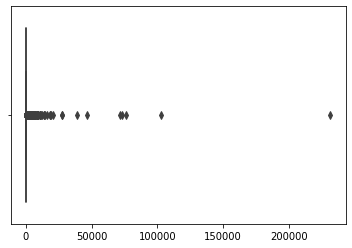

In [52]:
sns.boxplot(tx_counts)

In [53]:
np.quantile(tx_counts, .90)

160.0

In [55]:
sum([min(x, 1000) for x in tx_counts])

859630

In [ ]:
random.seed(42)
cluster_interaction_txes = {}
both_change_count = 0
for key in cluster_txes:
    for spend_cluster in cluster_txes[key]:
        
        all_cluster_txes = cluster_txes[key][spend_cluster]
        
        if len(all_cluster_txes) > 1000:
            all_cluster_txes = random.sample(all_cluster_txes, 1000)
        
        for tx in all_cluster_txes:
            spend_output_idx = tx.outputs.where(lambda o: output_cluster_id(o) == spend_cluster).index
            assert len(spend_output_idx) > 0
            if len(spend_output_idx) == 2:
                both_change_count += 1
                continue
            cluster_interaction_txes[str(tx.hash)] = spend_output_idx[0]

In [57]:
len(cluster_interaction_txes)

859270

In [58]:
cluster_interaction_df = get_ground_truth_df(cluster_interaction_txes, reset_index=False, spend_values=False)

Progress: 50000 out of 859270 transactions
Progress: 100000 out of 859270 transactions
Progress: 150000 out of 859270 transactions
Progress: 200000 out of 859270 transactions
Progress: 250000 out of 859270 transactions
Progress: 300000 out of 859270 transactions
Progress: 350000 out of 859270 transactions
Progress: 400000 out of 859270 transactions
Progress: 450000 out of 859270 transactions
Progress: 500000 out of 859270 transactions
Progress: 550000 out of 859270 transactions
Progress: 600000 out of 859270 transactions
Progress: 650000 out of 859270 transactions
Progress: 700000 out of 859270 transactions
Progress: 750000 out of 859270 transactions
Progress: 800000 out of 859270 transactions
Progress: 850000 out of 859270 transactions
Non-standard: 0
No heuristics: All spent: 8745, Unspent: 4593
Reuse: Correct: 117421, Incorrect: 0
Cluster: Correct: 459737, Incorrect: 0


In [62]:
len(cluster_interaction_df), len(cluster_interaction_df) // 2

(537548, 268774)

In [63]:
cluster_interaction_df.to_csv("/home/ubuntu/Data/model-validation/{}-cluster-interaction-extensive-gt.csv".format(date_string))

In [61]:
cluster_interaction_df.head()

,true_change,optimal_change,optimal_change_with_fee,address_type,power_of_ten_2,power_of_ten_3,power_of_ten_4,power_of_ten_5,power_of_ten_6,power_of_ten_7,...,co_other_fresh,ct_fee,ct_fee_per_byte,ct_tx_value,ct_segwit_tx,ct_has_locktime,ct_version,ct_block_height,ct_input_count,all_outputs_spent
3942bfd527bde40e3b340fe2e076772780f6a63a84da87ace0e82c6cd8dcffbe-0,1,-1,-1,-1,-1,-1,-1,1,1,-1,...,False,50000,221,26950000,0,False,1,239939,1,True
3942bfd527bde40e3b340fe2e076772780f6a63a84da87ace0e82c6cd8dcffbe-1,0,-1,-1,-1,-1,-1,-1,0,0,-1,...,True,50000,221,26950000,0,False,1,239939,1,True
4d0ebb3ec54024f25b65baf79d788b7222902dd7b343ce9d409eab2cbfdcd3e9-0,1,-1,-1,-1,-1,-1,-1,-1,-1,0,...,False,50000,74,6871000000,0,False,1,321697,4,True
4d0ebb3ec54024f25b65baf79d788b7222902dd7b343ce9d409eab2cbfdcd3e9-1,0,-1,-1,-1,-1,-1,-1,-1,-1,1,...,True,50000,74,6871000000,0,False,1,321697,4,True
8534a43295b277c08c50b9d0c62bc18524c3fbc71cb4395b1cb13dd37342903c-0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,True,50000,220,10658190000,0,False,1,325556,1,True


In [ ]:
cluster_interaction_extended_txes = [txhash[:-2] for txhash, _ in utils.grouper(cluster_interaction_df.index, 2)]

In [ ]:
cluster_interaction_extended_txes_timestamps = [chain.tx_with_hash(txhash).block.time for txhash in cluster_interaction_extended_txes]

In [ ]:
pd.Series(cluster_interaction_extended_txes_timestamps).hist()

In [ ]:
combinations = 0
sizes = []
for key in cluster_txes:
    combinations += len(cluster_txes[key])
    for key2 in cluster_txes[key]:
        sizes.append(len(cluster_txes[key][key2]))
    

In [ ]:
combinations / (272**2)